In [0]:
import os
import unicodedata
import string
import random
from __future__ import unicode_literals, print_function, division
import time
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

In [0]:
if not os.path.exists('data'):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip 
    !sudo rm -r data.zip

In [0]:
class generate_dataset(Dataset):
    
    def __init__(self,root_dir):
        self.letters = string.ascii_letters + " .,;'"

        self.names_categorized = {}
        self.languages = []

        for filename in os.listdir(root_dir):
            category = os.path.splitext(os.path.basename(filename))[0]
            self.languages.append(category)
            self.names_categorized[category] = self.read_lines(os.path.join('data/names',filename))

    def unicode_to_ascii(self,s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in self.letters
        )

    def read_lines(self,filename):
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        return [self.unicode_to_ascii(line) for line in lines]

    def tensor_to_language(self,tensor):
        return self.languages[tensor.argmax().item()]
    
    def len_letters(self):
        return len(self.letters)

    def len_languages(self):
        return len(self.languages)

    def categories(self):
        return self.languages

    def get_letters(self):
        return self.letters        

    # One-hot vector for category
    def category_one_hot_tensor(self,category):
        index = self.languages.index(category)
        tensor = torch.zeros(1, len(self.languages))
        tensor[0][index] = 1
        return tensor

    # One-hot matrix of first to last letters (not including EOS) for input
    def input_tensor(self,line):
        tensor = torch.zeros(len(line), 1, len(self.letters))
        for i in range(len(line)):
            letter = line[i]
            tensor[i][0][self.letters.find(letter)] = 1
        return tensor

    # LongTensor of second letter to end (EOS) for target
    def target_tensor(self,line):
        letter_indexes = [self.letters.find(line[i]) for i in range(1, len(line))]
        letter_indexes.append(len(self.letters) - 1) # EOS
        return torch.LongTensor(letter_indexes).unsqueeze_(-1)
    
    def random_sample(self):  
        category = random.choice(self.languages)
        line = random.choice(self.names_categorized[category])

        category_tensor = self.category_one_hot_tensor(category)
        input_tensor = self.input_tensor(line)
        target_tensor = self.target_tensor(line)
        return category, line, category_tensor, input_tensor, target_tensor

dataset = generate_dataset('data/names')

In [51]:
category, line, category_tensor, input_tensor, target_tensor = dataset.random_sample()
print(category)
print(line)
print(category_tensor.shape)
print(input_tensor.shape)
print(target_tensor.shape)

Japanese
Nakadan
torch.Size([1, 18])
torch.Size([7, 1, 57])
torch.Size([7, 1])


##Network
![alt text](https://i.imgur.com/jzVrf7f.png)

In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(dataset.len_languages() + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(dataset.len_languages() + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

num_letters = dataset.len_letters()
rnn = RNN(num_letters, 128, num_letters)

For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

The category tensor is a one-hot tensor of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

![alt text](https://i.imgur.com/JH58tXY.png)

In [62]:
learning_rate = 0.00001
n_iters = 100000
print_every = 5000
loss = 0
losses = []

criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):

    hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss_word = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss_step = criterion(output, target_line_tensor[i])
        loss_word += loss_step 
 
    loss_word.backward(retain_graph=True)

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss_word.item() / input_line_tensor.size(0)

# Training Loop
for iter in range(1, n_iters + 1):
    category, line, category_tensor, input_tensor, target_tensor = dataset.random_sample()
    output, loss_epoch = train(category_tensor, input_tensor, target_tensor)
    loss += loss_epoch

    if iter % print_every == 0:
        print('Iteration: %d   Loss: %.4f' % (iter, loss/print_every))
        losses.append(loss / print_every)
        loss = 0

Iteration: 5000   Loss: 2.2579
Iteration: 10000   Loss: 2.2598
Iteration: 15000   Loss: 2.2533
Iteration: 20000   Loss: 2.2538
Iteration: 25000   Loss: 2.2683
Iteration: 30000   Loss: 2.2600
Iteration: 35000   Loss: 2.2482
Iteration: 40000   Loss: 2.2498
Iteration: 45000   Loss: 2.2519
Iteration: 50000   Loss: 2.2504
Iteration: 55000   Loss: 2.2503
Iteration: 60000   Loss: 2.2583
Iteration: 65000   Loss: 2.2625
Iteration: 70000   Loss: 2.2561
Iteration: 75000   Loss: 2.2571
Iteration: 80000   Loss: 2.2640
Iteration: 85000   Loss: 2.2528
Iteration: 90000   Loss: 2.2434
Iteration: 95000   Loss: 2.2530
Iteration: 100000   Loss: 2.2373


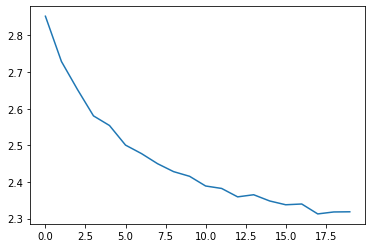

In [10]:
plt.figure()
plt.plot(losses)

In [78]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  
        category_tensor = dataset.category_one_hot_tensor(category)
        input = dataset.input_tensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden) 
            top_idx = output.argmax()
            if top_idx == dataset.len_letters() - 1:
                break
            else:
                letter = dataset.get_letters()[top_idx]
                output_name += letter
            input = dataset.input_tensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'A')

Allan
